In [285]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

In [419]:
def draw_image(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis('off') 
    plt.show()

In [286]:
# ПОЛУЧАЕМ ПЕРВЫЙ КАДР ИЗ ВИДЕО

cap = cv2.VideoCapture('src/assets/demo.mp4')
    
if (cap.isOpened()== False): 
    print("Error opening video file") 

version = 1

ret, video = cap.read()
cv2.imwrite('src/assets/demo.png', video)

cap.release()

In [287]:
# ЧИТАЕМ СОХРАНЕННОЕ ИЗОБРАЖЕНИЕ

image = cv2.imread('src/assets/demo.png')

image.shape

(1080, 1920, 3)

In [288]:
color = (0, 255, 0)  # Зеленый
thickness = 2  # Толщина линии
is_closed = True  # Замкнутый контур

processed_image = image.copy()

# [x,y] - x - расстояние от левого края, y - от верха
p1 = [342, 848] # левый низ
p2 = [346, 238] # левый верх
p3 = [1580, 236] # правый верх
p4 = [1584, 848] # правый низ

points = np.array([p1,p2,p3,p4])
points = points.reshape((-1, 1, 2))

cv2.polylines(processed_image, [points], isClosed=is_closed, color=color, thickness=thickness)

print()

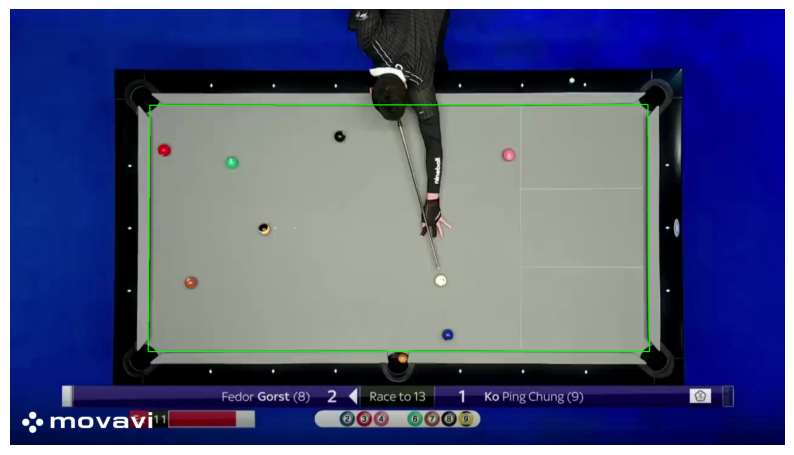

In [421]:
color = (0, 255, 0)  # Зеленый
thickness = 2  # Толщина линии
is_closed = True  # Замкнутый контур

processed_image = image.copy()

# [x,y] - x - расстояние от левого края, y - от верха
p1 = [346, 238] # левый верх
p2 = [1580, 236] # правый верх
p3 = [1584, 848] # правый низ
p4 = [342, 848] # левый низ

points = np.array([p1,p2,p3,p4])
points = points.reshape((-1, 1, 2))

cv2.polylines(processed_image, [points], isClosed=is_closed, color=color, thickness=thickness)

draw_image(processed_image)

In [291]:
# ПОЛУЧЕННЫЕ РАЗМЕРЫ

# стол ???
table_p_1 = [310, 884]
table_p_2 = [314, 204]
table_p_3 = [1610, 204]
table_p_4 = [1614, 884]

# внутренняя поверхность
inside_p_1 = [346, 238]
inside_p_2 = [1580, 236]
inside_p_3 = [1584, 848]
inside_p_4 = [342, 848]

# по бортам
bort_p_1 = [314, 204]
bort_p_2 = [1610, 204]
bort_p_3 = [1614, 884]
bort_p_4 = [310, 884]

# размер шара в px
radius = 14

разрешение больше в 5 раз - 5пкс == 1см
размер стола - 112см × 224см
диаметр шара - 57мм

In [292]:
# ПОЛУЧЕНИЕ КРОПНУТОГО ИЗОБРАЖЕНИЕ ВНУТРЕННЕЙ ЧАСТИ СТОЛА

# Определение четырех точек прямоугольника на исходном изображении
pts_src = np.array([inside_p_1,inside_p_2,inside_p_3,inside_p_4], dtype=np.float32)

# Определение размеров прямоугольника в результирующем изображении
width, height = 1120, 560
pts_dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=np.float32)

# Получение матрицы перспективного преобразования
matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)

# Применение перспективного преобразования к исходному изображению
inside_image = cv2.warpPerspective(image, matrix, (width, height))

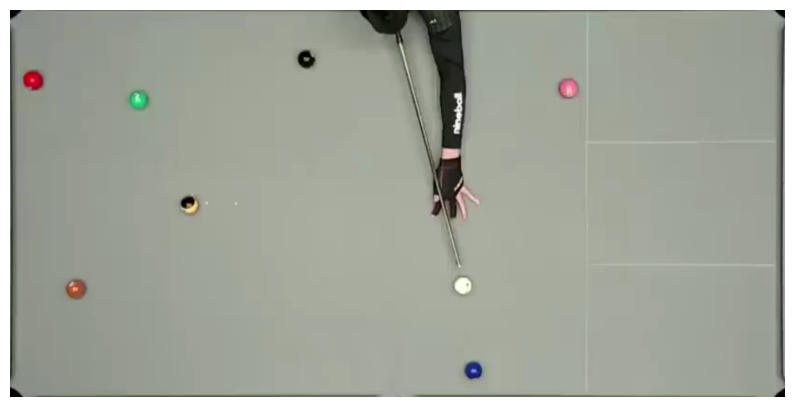

In [293]:
# ОТОБРАЖЕНИЕ КАРТИНКИ ДЛЯ ПОДБОРА ПАРАМЕТРОВ

image_rgb = cv2.cvtColor(inside_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off') 
plt.show()

[[ 32 104  14]
 [654 398  11]
 [186 132  14]
 [ 94 404  15]
 [258 284  15]
 [808 114  14]
 [428  72  12]
 [668 522  12]]


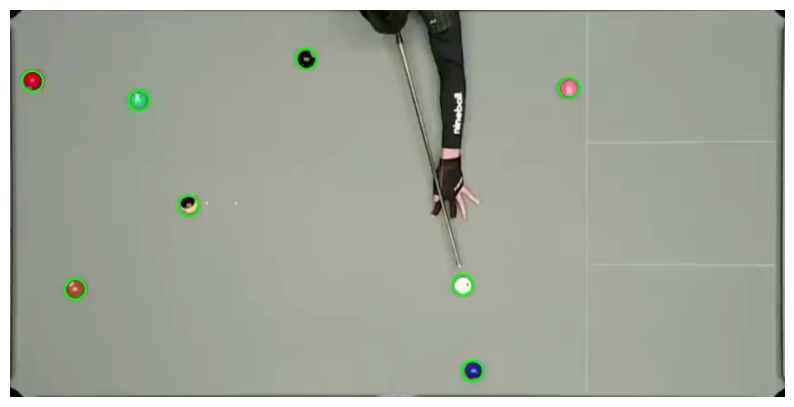

In [429]:
img = inside_image.copy()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=9, param1=22, param2=22, minRadius=10, maxRadius=22)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")

    print(circles)

    for (x, y, _) in circles:
        cv2.circle(img, (x, y), radius, (0, 255, 0), 2)
else:
    print("No circles detected.")

draw_image(img)

In [430]:
# ПОЛУЧЕНИЕ ЦЕНТРОВ ШАРОВ

radius = 15
balls = list(map(lambda circle: [circle[0], circle[1]], circles))
balls

[[32, 104],
 [654, 398],
 [186, 132],
 [94, 404],
 [258, 284],
 [808, 114],
 [428, 72],
 [668, 522]]

In [431]:
# ПОИСК БЕЛОГО ШАРА

img = inside_image.copy()

# Бинаризация
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)

def calculate_brightness(img, center, radius):
    x, y = center
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.circle(mask, (x, y), radius, 1, -1)
    brightness = np.sum(img * mask)
    return brightness

max_brightness = 0
brightest_center = None

for center in balls:
    brightness = calculate_brightness(img, center, radius)
    if brightness > max_brightness:
        max_brightness = brightness
        brightest_center = center

print(brightest_center)

[654, 398]


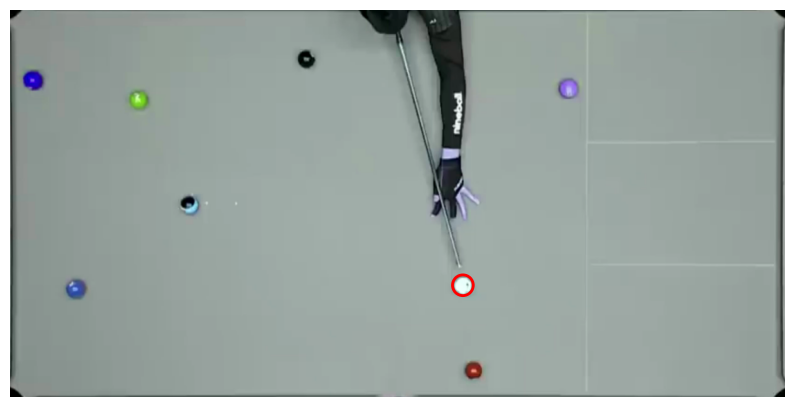

In [298]:
# ОТОБРАЖЕНИЕ БЕЛОГО ШАРА

plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')
if brightest_center:
    circle = plt.Circle(brightest_center, radius, color='r', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
plt.axis('off')
plt.show()

32
20


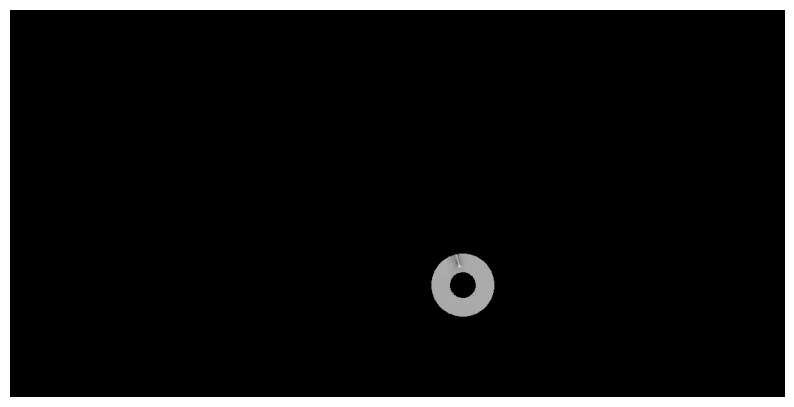

In [432]:
# ПОЛУЧЕНИЕ МАСКИ В ОКРЕСТНОСТЯХ ШАРА ДЛЯ ПОИСКА КИЯ

img = inside_image.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

x, y = brightest_center
search_radius = radius + 30
spread_radius = radius + 5

mask_radius = int(spread_radius + (search_radius - spread_radius) / 2)
mask_thickness = int(search_radius - spread_radius)

print(mask_radius)
print(spread_radius)

mask = np.zeros_like(img, dtype=np.uint8)
cv2.circle(mask, (x, y), mask_radius, 1, mask_thickness)
cue_mask = img * mask

draw_image(cue_mask)

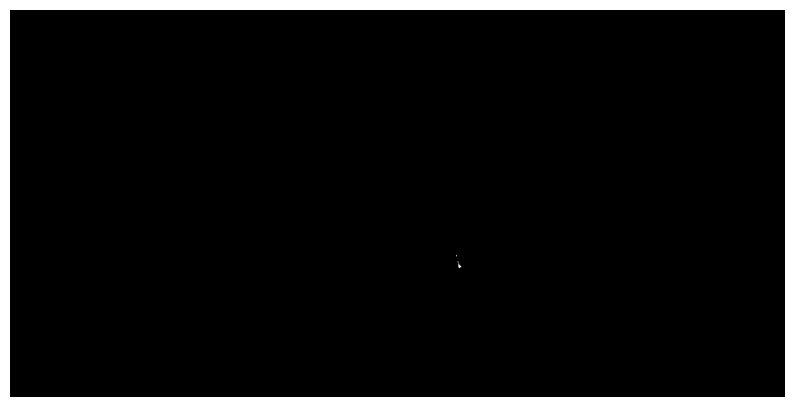

In [433]:
# СОЗДАНИЕ БИНАРНОЙ МАСКИ ДЛЯ ПОИСКА КИЯ

img = cue_mask.copy()
_, cue_mask_binary = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY)

draw_image(cue_mask_binary)

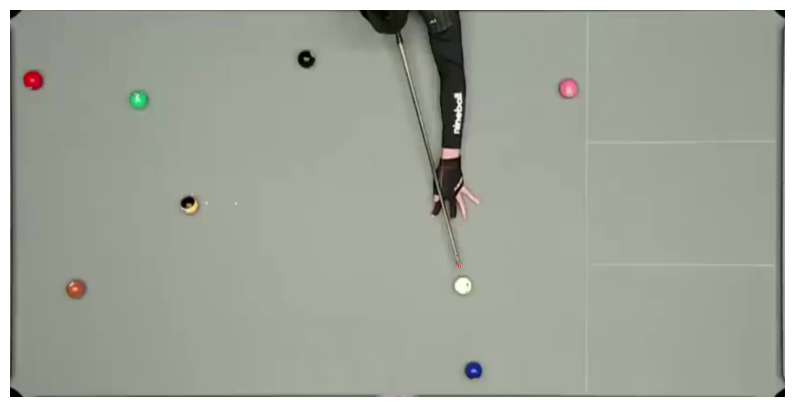

In [434]:
# ПОИСК КОНТУРОВ В БИНАРНОЙ МАСКЕ ДЛЯ ПОИСКА КИЯ

binary_mask = cue_mask_binary.copy()
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img = inside_image.copy()

if (len(contours) == 0):
    print('КОНТУРА НЕ НАЙДЕНЫ БЛЕАТЬ!')

for contour in contours:
    cv2.drawContours(img, [contour], -1, (0, 0, 255), 1)

draw_image(img)


In [435]:
# ПОЛУЧЕНИЕ НАИБОЛЕЕ ПОХОЖЕГО НА КИЙ КОНТУРА И ПОЛУЧЕНИЕ ЕГО ЦЕНТРА
# ------------------------------------------
# площадь при текущем разрешении примерно 7-10, если такая площадь не одна,
# либо только нулевые площади, то берем ближайший контур

potential_sizes = [7, 10]
warning_potential_sizes = [5, 15]

def get_cue(contour):
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return [cX, cY]
    else:
        return contour[0][0]
    

def get_cue_contour(contours):
    min_size = 1_000
    min_size_idx = 0

    for idx, contour in enumerate(contours):
        if (contour[1] < min_size):
            min_size = contour[1]
            min_size_idx = idx

    return contours[min_size_idx][0]

def get_potential_contours(contours):
    # проверяем в лучшем диапазоне
    potential_contours = [c for c in handle_contours if c[1] >= potential_sizes[0] and c[1] <= potential_sizes[1]]
    
    if (len(potential_contours) != 0):
        return potential_contours
    
    # проверяем в расширенном диапазоне
    potential_contours = [c for c in handle_contours if c[1] >= warning_potential_sizes[0] and c[1] <= warning_potential_sizes[1]]

    if (len(potential_contours) != 0):
        return potential_contours
    
    # проверяем в 0 диапазоне
    potential_contours = [c for c in handle_contours if c[1] == 0]
    
    if (len(potential_contours) != 0):
        return potential_contours
    
    return contours

handle_contours = []

for contour in contours:
    area = cv2.contourArea(contour)
    handle_contours.append((contour, area))

potential_contours = get_potential_contours(handle_contours)
cue_contour = get_cue_contour(potential_contours)
cue = get_cue(cue_contour)

cue

[649, 370]

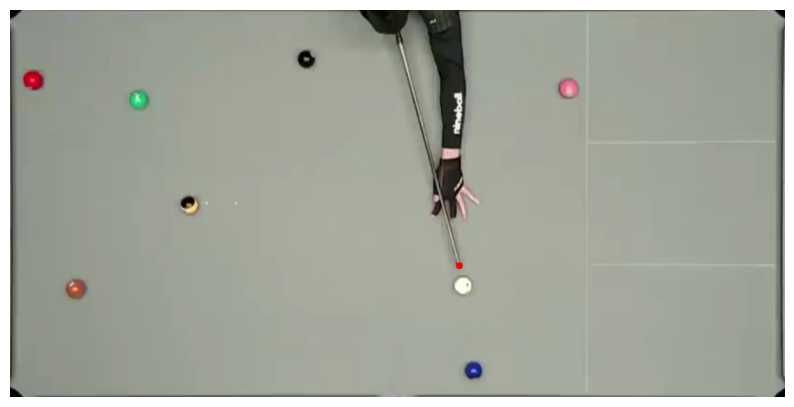

In [436]:
# ВЫВОД ТОЧКИ КИЯ

img = inside_image.copy()
cv2.circle(img, cue, 5, (0, 0, 255), -1)

draw_image(img)


In [437]:
#  ОБРАБОТКА ПОЛУЧЕННОЙ ИНФОРМАЦИИ

balls = list(filter(lambda b: b[0] != brightest_center[0] and b[1] != brightest_center[1], balls))
cue_ball = brightest_center

print('Размер шара:', radius)
print('Координаты шаров:', balls)
print('Координаты битка:', cue_ball)
print('Координаты кия:', cue)
print('Размеры игровой зоны:', (width, height))

Размер шара: 15
Координаты шаров: [[32, 104], [186, 132], [94, 404], [258, 284], [808, 114], [428, 72], [668, 522]]
Координаты битка: [654, 398]
Координаты кия: [649, 370]
Размеры игровой зоны: (1120, 560)


# Маршрут движения шара

In [438]:
# УРАВНЕНИЕ ПРЯМОЙ

def linear_equation(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    
    if x2 - x1 != 0:
        m = (y2 - y1) / (x2 - x1)
    else:
        m = float('inf')
    
    b = y1 - m * x1
    
    return m, b

k, b = linear_equation(cue_ball, cue)

print(f"Уравнение прямой: y = {k}x + {b}")


Уравнение прямой: y = 5.6x + -3264.3999999999996


In [457]:
# ПОИСК ТОЧКИ ПЕРЕСЕЧЕНИЯ С ГРАНИЦАМИ 

def get_intercection(k, b, is_left_to_right, is_top_to_bottom):
    intercections = []

    # проверка верхней границы
    def top():
        x = -b / k
        y = 0
        
        return (x, y)
    
    # проверка правой границы
    def right():
        y = k * width + b
        x = width
        
        return (x, y)
    
    # проверка нижней границы
    def bottom():
        x = (height - b) / k
        y = height
        
        return (x, y)
    
    # проверка левой границы
    def left():
        y = b
        x = 0
        
        return (x, y)
    
    if (is_left_to_right): intercections.append([right(), 'right'])
    else: intercections.append([left(), 'left'])

    if (is_top_to_bottom): intercections.append([bottom(), 'bottom'])
    else: intercections.append([top(), 'top'])

    # поиск валидного пересечения
    valid_intercections = list(filter(lambda intercection: 0 <= intercection[0][0] <= width and 0 <= intercection[0][1] <= height, intercections))

    if (len(valid_intercections) == 0):
        print('ОШИБКА: не найдено')

    if (len(valid_intercections) > 1):
        print('Что-то пошло не так, больше 1 пересечения')

    return valid_intercections[0]


[(782.9285714285714, 0), 'top']

In [ ]:
# ПОИСК ПАРАМЕТРОВ ПОСЛЕ ОПРЕДЕЛЕНИЯ ПЕРВОЙ ТОЧКИ

def get_params_after_intercection(k, b, intercection):
    side = intercection[1]

    k = -k
    b = intercection[0][1] * 2 - b
    is_left_to_right = intercection[1] == 'bottom' or (k < 0 and side == 'bottom') or (k > 0 and side == 'top')
    is_top_to_bottom = intercection[1] == 'top' or (k < 0 and side == 'right') or (k > 0 and side == 'left')

    return (k, b, is_left_to_right, is_top_to_bottom)

In [ ]:
intercections = []

intercection = get_intercection(k, b, cue[0] < cue_ball[0], cue[0] < cue_ball[0])
intercection.append(intercection)

params = get_params_after_intercection(k, b, intercection)
intercection = get_intercection(*params)
intercection.append(intercection)

intercection = get_intercection(k, b, cue[0] < cue_ball[0], cue[0] < cue_ball[0])
intercection.append(intercection)

intercection
